In [1]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.utils import Sequence

from datetime import datetime
from scipy.optimize import linear_sum_assignment
import random
import matplotlib.pyplot as plt
import numpy as np
import cv2 
import os
from scipy.optimize import linear_sum_assignment as lsa
from imgaug import augmenters as iaa
from math import ceil
import pandas as pd
import requests
import sklearn

# Data Generator

In [2]:
BATCH_SIZE = 8
IMG_SIZE = 100
class Wt_Image(Sequence):  #sequence클래스 상속
  #객체 생성인자로 들어온 값을 객체 내부 변수로 할당
  def __init__(self, image_filenames, batch_size = BATCH_SIZE, augmentor=None, shuffle=False, pre_func=None):
    '''
    image_filenames : image로드할 파일의 절대경로
    shuffle : 학습 데이터의 epoch 종료시마다 데이터를 섞을지 여부 --주의
    '''
    #초기화
    self.image_filenames = image_filenames
    self.batch_size = batch_size
    self.augmentro = augmentor
    self.shuffle = shuffle
    self.pre_func = pre_func

    
  def __len__(self):
    '''
    Sequence를 상속받은 dataset은 batch_size 단위로 입력된 데이터를 처리
    batch_size 단위로 데이터를 몇번 가져와야 하는지 계산. 전체 데이터 건수를 batch_size로 나뉘도, 정수로 정확히 나눠지지 않을 경우 1회 더함
    '''
    return int(np.ceil(len(self.image_filenames)/self.batch_size))
  
  
  def __getitem__(self, index):
    '''
    batch_size 단위로 image_array, label_array 데이터를 가져와서 변환한 뒤 다시 반환함.
    인자로 몇번째 batch인지를 나타내는 index를 입력하면 해당 순서에 해당하는 batch_size만큼의 데이터를 가공하여 반환.
    batch_size 개수만큼 변환된 image_array, label_array 반환
    '''
    #(Batch-sized) IMAGE url array 
    image_name_batch = self.image_filenames[index*self.batch_size:(index+1)*self.batch_size]  #batch_size만큼의 image name array
        
    #IMAGE CONTAINER
    image_batch = np.zeros((image_name_batch.shape[0], IMG_SIZE, IMG_SIZE, 3)) #영행렬 shape - (batch_size, height, width, channel)
    image_trans_batch = np.zeros((image_name_batch.shape[0], IMG_SIZE, IMG_SIZE, 3))
    
    #IMAGE        
    for image_index in range(image_name_batch.shape[0]):  #배치 안에 잇는 이미지 꺼내기

      #image
      image_nparray = np.asarray(bytearray(requests.get(image_name_batch[image_index]).content)) #url
      image = cv2.imdecode(image_nparray, cv2.IMREAD_COLOR) #image decode
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #convert bgr to rgb
      image = cv2.resize(image, (IMG_SIZE, IMG_SIZE)) #필요하면 이미지 사이즈 조정.
      #image = image.astype('float32')
        
      #augmented image
      rand_val = random.sample(range(3), 1)
      if rand_val == [0]:
        image_trans = crop_transf(image, 25)
      elif rand_val ==[1]:
        image_trans = flip(image)
      elif rand_val ==[2]:
        image_trans = rotate(image)
        
      #put in an image-array
      image_batch[image_index] = image
      image_trans_batch[image_index] = image_trans
      
    return ([image_batch, image_trans_batch], np.zeros((BATCH_SIZE, 1)).astype('float32'))

  def on_epoch_end(self):
    '''
    epoch를 각 한번 수행 완료될 때마다 모델의 fit()에서 호출함
    epoch마다 shuffle을 할지말지 정하는 것.
    '''
    if(self.shuffle):
      self.image_filename = sklearn.utils.shuffle(self.image_filenames) #Image url 섞어주기.
    else:
      pass  


## 이미지 가져오기(이미지 확인용)

In [ ]:
old = pd.read_csv('old_image_table.csv')
new = pd.read_csv('image_table.csv')

In [ ]:
IMG_SIZE = 100 #이미지 사이즈 
image_batch = np.zeros((8, IMG_SIZE, IMG_SIZE, 3))

for url in new['page_image'][1:9]:
    i=0
    image_nparray = np.asarray(bytearray(requests.get(url).content)) #url
    image = cv2.imdecode(image_nparray, cv2.IMREAD_COLOR) #image decode
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #convert bgr to rgb
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image_batch[i] = image
    i+=1

## Transformations
- crop
- 좌우반전
- 랜덤으로 회전

In [ ]:
# crop
def crop_transf(batch, crop_fraction):
    uncropped_size = IMG_SIZE - int((crop_fraction*IMG_SIZE)//100)
    crop = tf.keras.Sequential([
        layers.experimental.preprocessing.CenterCrop(height = uncropped_size, width= uncropped_size),
        layers.experimental.preprocessing.Resizing(height=IMG_SIZE, width = IMG_SIZE)])
    batch = crop(batch)
    return batch

#좌우반전
flip = tf.keras.Sequential([layers.experimental.preprocessing.RandomFlip(mode='horizontal')])

#랜덤으로 회전
rotate = tf.keras.Sequential([
                              layers.experimental.preprocessing.RandomRotation(factor=15, fill_mode='nearest', interpolation='bilinear')
])

In [ ]:
crop_image = crop_transf(image, 25)
crop_image = np.array(crop_image).astype('int32')

flip_image = flip(image)
flip_image = np.array(flip_image).astype('int32')

rotate_image = rotate(image)
rotate_image = np.array(rotate_image).astype('int32')

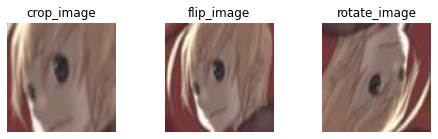

In [ ]:
fig, axes = plt.subplots(figsize=(8, 2), nrows=1, ncols=3)
axes[0].imshow(crop_image)
axes[0].axis('off')
axes[0].set_title('crop_image')
axes[1].imshow(flip_image)
axes[1].axis('off')
axes[1].set_title('flip_image')
axes[2].imshow(rotate_image)
axes[2].axis('off')
axes[2].set_title('rotate_image')
plt.show()

# Model

In [ ]:
MAIN_OUTPUT_UNITS = 20 #몇개로 분류가 될지 선택.

def networkB(input, filters):
  X = input
  F1, F2, F3, F4 = filters

  #BLOCK 1
  X = Conv2D(filters = F1, kernel_size=(5, 5), strides = (1, 1), padding='same', kernel_initializer='random_normal', use_bias=False)(X)
  X = BatchNormalization(axis=-1)(X) #channel
  X = Activation('relu')(X)
  X = MaxPool2D(pool_size=(2,2), strides=(2,2), padding='same')(X)

  #BLOCK 2
  X = Conv2D(filters = F2, kernel_size=(3, 3), strides = (1, 1), padding='same', kernel_initializer='random_normal', use_bias=False)(X)
  X = BatchNormalization(axis=-1)(X) #channel
  X = Activation('relu')(X)
  X = MaxPool2D(pool_size=(2,2), strides=(2,2), padding='same')(X)

  #BLOCK 3
  X = Conv2D(filters = F3, kernel_size=(3, 3), strides = (1, 1), padding='same', kernel_initializer='random_normal', use_bias=False)(X)
  X = BatchNormalization(axis=-1)(X) #channel
  X = Activation('relu')(X)
  X = MaxPool2D(pool_size=(2,2), strides=(2,2), padding='same')(X)

  #BLOCK 4
  X = Conv2D(filters = F4, kernel_size=(3, 3), strides = (1, 1), padding='same', kernel_initializer='random_normal', use_bias=False)(X)
  X = BatchNormalization(axis=-1)(X) #channel
  X = Activation('relu')(X)
  X = MaxPool2D(pool_size=(2,2), strides=(2,2), padding='same')(X)

  #BLOCK 5
  X = Flatten()(X)
  return X


#---------- Define single_model ----------###
# INPUT - image data
input = Input([IMG_SIZE, IMG_SIZE, 3])

# NETWORK (input -> networkB)      #CNN
base_output= networkB(input, [64, 128, 256, 512]) #networkB(input, filters)

# OUTPUT     #FC
output = Dense(MAIN_OUTPUT_UNITS ,activation='softmax', kernel_initializer='random_normal', bias_initializer='zeros')(base_output)

# MODEL(Input->output)
single_model = Model(inputs=input, outputs=output, name='single_head_model')


#---------- Define IIC_model ----------#

#INPUT  -  image, augmented_image
input1 = Input([IMG_SIZE,IMG_SIZE,3])
input2 = Input([IMG_SIZE,IMG_SIZE,3])

#two models OUTPUT (single_model + single_model)
models_output = Concatenate(name='models_output')([single_model(input1),single_model(input2)]) #layers concatenate

#concatenate -> compute entropy -> compute mutual information

# IIC_model (Input->output)
IIC_model = Model(inputs=[input1, input2], outputs = [models_output])

#Loss

In [ ]:
def main_loss(y_true,y_pred,batch_size=BATCH_SIZE,lamb=1):  #y_true는 (batch_size,1) 모양의 영행렬

    k=MAIN_OUTPUT_UNITS
    y_pred=tf.squeeze(y_pred) #차원축소

    #Divide the outputs that have been concatenated 
    phi1=tf.squeeze(y_pred[:,0:MAIN_OUTPUT_UNITS])      #single_model for Input1
    phi2=tf.squeeze(y_pred[:,MAIN_OUTPUT_UNITS:])       #single_model for Input2

    P= tf.reduce_sum(tf.expand_dims(phi1, 2) * tf.expand_dims(phi2, 1), 0)

    #Symmetrize P matrix
    P=tf.add(P,tf.transpose(P))/2   #P = 1/n * S I(x) * I(x')T

    #Add eps value in order to avoid 0 values in P
    P=tf.clip_by_value(P,clip_value_min=1e-6,clip_value_max=1e9)   

    P/=tf.reduce_sum(P)

    pi = tf.broadcast_to(tf.reshape(tf.reduce_sum(P, axis=0), (k, 1)), (k, k))  #Pc
    pj = tf.broadcast_to(tf.reshape(tf.reduce_sum(P, axis=1), (1, k)), (k, k))  #Pc'
    loss = -tf.reduce_sum(P * (tf.math.log(P) - lamb * tf.math.log(pi) - lamb * tf.math.log(pj)))  #I(z, z') = SSP * logPcc' - logPc - logPc'

    return loss

#Callback

In [ ]:
!mkdir "/content/drive/MyDrive/IIC"

In [ ]:
CP_HEAD_ITERATIONS=10
CP_IIC_MODEL_ITERATIONS=50

class  CustomCallback(Callback):

    def on_epoch_begin(self, epoch, logs=None):
      if epoch%CP_HEAD_ITERATIONS==0:

        checkpoint_m1="/content/drive/MyDrive/IIC/cp_head_"+str(epoch)+".h5"
        single_model.save_weights(checkpoint_m1)


      if epoch%CP_IIC_MODEL_ITERATIONS==0:
        checkpoint_IIC="/content/drive/MyDrive/IIC/cp_IIC_"+str(epoch)+".h5"
        IIC_model.save_weights(checkpoint_IIC)


In [ ]:
## model parameter##
INIT_LR = 1e-4
losses = [main_loss]   #main_loss 함수
lossWeights = (1)
opt = Adam(lr=INIT_LR)
BATCH_SIZE = 8
IMG_SIZE = 100

## compile ##
IIC_model.compile(optimizer = opt, loss = losses, loss_weights = lossWeights, run_eagerly=False)

## data generator ##
url_ls = old.page_image.values
image_data = Wt_Image(url_ls, batch_size = BATCH_SIZE, shuffle=True)


## fit ##
EPOCHS = 10
history = IIC_model.fit(image_data,
              steps_per_epoch=int(np.ceil(url_ls.shape[0] / BATCH_SIZE)), #전체데이터/batch 개수
              epochs=EPOCHS,
              verbose=1,
              callbacks = [CustomCallback()])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/10
362/362 [==============================] - 842s 2s/step - loss: -1.3660
Epoch 2/10
362/362 [==============================] - 832s 2s/step - loss: -1.4776
Epoch 3/10
362/362 [==============================] - 838s 2s/step - loss: -1.4933
Epoch 4/10
362/362 [==============================] - 838s 2s/step - loss: -1.5632
Epoch 5/10
362/362 [==============================] - 818s 2s/step - loss: -1.5642
Epoch 6/10
362/362 [==============================] - 821s 2s/step - loss: -1.6068
Epoch 7/10
362/362 [==============================] - 850s 2s/step - loss: -1.5949
Epoch 8/10
362/362 [==============================] - 834s 2s/step - loss: -1.6151
Epoch 9/10
362/362 [==============================] - 831s 2s/step - loss: -1.6293
Epoch 10/10
362/362 [==============================] - 832s 2s/step - loss: -1.5916


In [ ]:
def  CustomMetric(model,x_true,y_true, num_classes):

    x_true=resize(x_true)
  
    #x_true=tf.image.rgb_to_grayscale(x_true)
    softmax_predictions=model.predict(x_true)
    predictions=[np.argmax(x) for x in softmax_predictions]
  
    # initialize count matrix
    cnt_mtx = np.zeros([num_classes, num_classes])

    # fill in matrix
    for i in range(len(y_true)):
        cnt_mtx[int(predictions[i]), int(y_true[i])] += 1

    # find optimal permutation
    row_ind, col_ind = linear_sum_assignment(-cnt_mtx)
    #print(row_ind)
    #print(col_ind)

    # compute error
    error = 1 - cnt_mtx[row_ind, col_ind].sum() / cnt_mtx.sum()

    # print results
    #print('Classification error = {:.4f}'.format(error))

    return error

# 클러스터 예측 확인

In [ ]:
url_ls = old.page_image.values
image_test = Wt_Image(url_ls, batch_size = BATCH_SIZE, shuffle=True)
predictions = IIC_model.predict(image_test)

In [ ]:
predictions.shape

(2890, 40)

In [ ]:
np.argmax(predictions[0])

10

In [ ]:
predictions[0][:20].shape

(20,)

## 클러스터 확인

In [ ]:
#cluster label
cluster_ls =[]
for i in range(len(predictions)):
  result = predictions[i][:20]
  cluster = np.argmax(result)
  cluster_ls.append(cluster)

In [ ]:
#cluster probability
cluster_proba =[]
for i in range(len(cluster_ls)):
  proba = predictions[i][cluster_ls[i]]
  cluster_proba.append(proba)

In [ ]:
cluster_ls = pd.Series(cluster_ls)
cluster_ls.value_counts().values

array([731, 419, 400, 260, 224, 214, 191, 114,  86,  82,  72,  67,  24,
         6])

<BarContainer object of 14 artists>

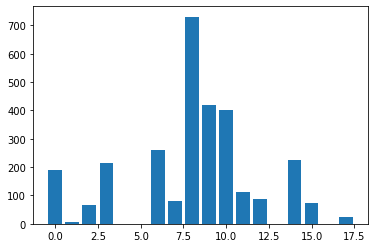

In [ ]:
#클러스터별 분포 확인
plt.bar(cluster_ls.value_counts().index, cluster_ls.value_counts().values)

# 이미지 테이블 + 클러스터 name


In [ ]:
df = pd.DataFrame({'cluster_name' : cluster_ls, 'cluster_proba' : cluster_proba})
df = df.reset_index()
df

,index,cluster_name,cluster_proba
0,0,10,0.999991
1,1,15,0.999997
2,2,15,0.989521
3,3,15,0.998126
4,4,15,0.998870
...,...,...,...
2885,2885,3,0.613684
2886,2886,6,1.000000
2887,2887,14,0.999939
2888,2888,6,0.644627


In [ ]:
old = pd.read_csv('old_image_table.csv')
old = old.reset_index()
old_cluster = pd.merge(old, df)

In [ ]:
old_cluster

,index,name,page_image,title,page_link,cluster_name,cluster_proba
0,0,나이트런,https://shared-comic.pstatic.net/thumb/webtoon...,예고편,https://comic.naver.com/webtoon/detail?titleId...,10,0.999991
1,1,나이트런,https://shared-comic.pstatic.net/thumb/webtoon...,1화,https://comic.naver.com/webtoon/detail?titleId...,15,0.999997
2,2,나이트런,https://shared-comic.pstatic.net/thumb/webtoon...,2화,https://comic.naver.com/webtoon/detail?titleId...,15,0.989521
3,3,나이트런,https://shared-comic.pstatic.net/thumb/webtoon...,3화,https://comic.naver.com/webtoon/detail?titleId...,15,0.998126
4,4,나이트런,https://shared-comic.pstatic.net/thumb/webtoon...,4화,https://comic.naver.com/webtoon/detail?titleId...,15,0.998870
...,...,...,...,...,...,...,...
2885,2885,니나의 마법서랍,https://shared-comic.pstatic.net/thumb/webtoon...,6화,https://comic.naver.com/webtoon/detail?titleId...,3,0.613684
2886,2886,니나의 마법서랍,https://shared-comic.pstatic.net/thumb/webtoon...,7화,https://comic.naver.com/webtoon/detail?titleId...,6,1.000000
2887,2887,니나의 마법서랍,https://shared-comic.pstatic.net/thumb/webtoon...,8화,https://comic.naver.com/webtoon/detail?titleId...,14,0.999939
2888,2888,니나의 마법서랍,https://shared-comic.pstatic.net/thumb/webtoon...,9화,https://comic.naver.com/webtoon/detail?titleId...,6,0.644627


## cluster 15

In [ ]:
url_cls15 = old_cluster[old_cluster.cluster_name == 15].page_image.values
proba_cls15 = old_cluster[old_cluster.cluster_name==15].cluster_proba.values
proba_cls15 = map(lambda x : np.round(x, 2), proba_cls15)
proba_cls15 = np.array(list(proba_cls15))

image_cls15 = np.zeros((len(url_cls15), 100, 100, 3))

for i in range(len(url_cls15)):
  image_nparray = np.asarray(bytearray(requests.get(url_cls15[i]).content)) #url
  image = cv2.imdecode(image_nparray, cv2.IMREAD_COLOR) #image decode
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #convert bgr to rgb
  image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
  image_cls15[i] = image

image_cls15 = image_cls15.astype('int32')
image_cls15.shape

(72, 100, 100, 3)

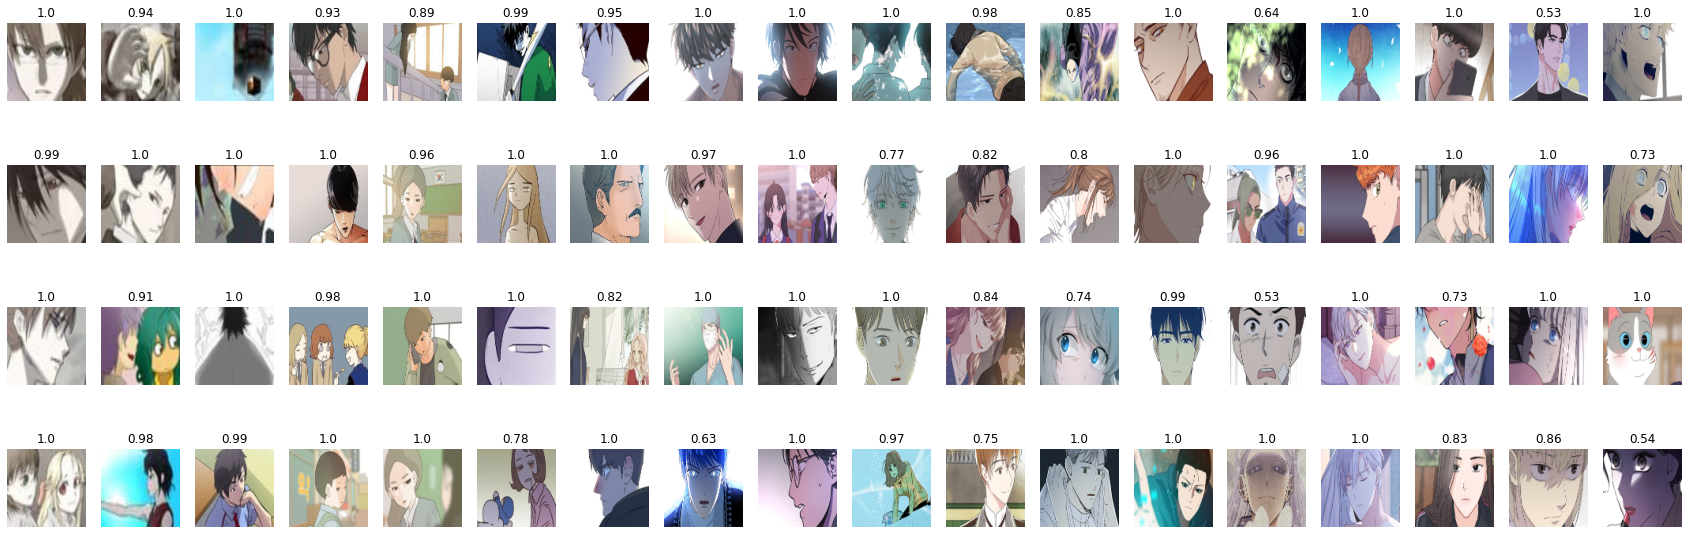

In [ ]:
fig, ax = plt.subplots(figsize=(30, 10), nrows=4, ncols=18)

for i in range(int(len(image_cls15)/4)):
  ax[0, i].imshow(image_cls15[4*i])
  ax[0, i].axis('off')
  ax[0, i].set_title('{}'.format(proba_cls15[4*i]))
  ax[1, i].imshow(image_cls15[4*i+1])
  ax[1, i].axis('off')
  ax[1, i].set_title('{}'.format(proba_cls15[4*i+1]))
  ax[2, i].imshow(image_cls15[4*i+2])
  ax[2, i].axis('off')
  ax[2, i].set_title('{}'.format(proba_cls15[4*i+2]))
  ax[3, i].imshow(image_cls15[4*i+3])
  ax[3, i].axis('off')
  ax[3, i].set_title('{}'.format(proba_cls15[4*i+3]))

plt.savefig('/content/drive/MyDrive/IIC/cluster_15.jpg')

## cluster 10

In [ ]:
#url
url_cls10 = old_cluster[old_cluster.cluster_name == 10].page_image.values
#cluster_probability
proba_cls10 = old_cluster[old_cluster.cluster_name==10].cluster_proba.values
proba_cls10 = map(lambda x : np.round(x, 2), proba_cls10)
proba_cls10 = np.array(list(proba_cls10))

#image
image_cls10 = np.zeros((len(url_cls10), 100, 100, 3))

for i in range(len(url_cls10)):
  image_nparray = np.asarray(bytearray(requests.get(url_cls10[i]).content)) #url
  image = cv2.imdecode(image_nparray, cv2.IMREAD_COLOR) #image decode
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #convert bgr to rgb
  image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
  image_cls10[i] = image

image_cls10 = image_cls10.astype('int32')
image_cls10.shape

In [ ]:
fig, ax = plt.subplots(figsize=(30, 30), nrows=20, ncols=20)

for i in range(int(len(image_cls10)/20)):
  ax[i, 0].imshow(image_cls10[20*i])
  ax[i, 0].axis('off')
  ax[i, 0].set_title('{}'.format(proba_cls10[20*i]))
  ax[i, 1].imshow(image_cls10[20*i+1])
  ax[i, 1].axis('off')
  ax[i, 1].set_title('{}'.format(proba_cls10[20*i+1]))
  ax[i, 2].imshow(image_cls10[20*i+2])
  ax[i, 2].axis('off')
  ax[i, 2].set_title('{}'.format(proba_cls10[20*i+2]))
  ax[i, 3].imshow(image_cls10[20*i+3])
  ax[i, 3].axis('off')
  ax[i, 3].set_title('{}'.format(proba_cls10[20*i+3]))
  ax[i, 4].imshow(image_cls10[20*i+4])
  ax[i, 4].axis('off')
  ax[i, 4].set_title('{}'.format(proba_cls10[20*i+4]))
  ax[i, 5].imshow(image_cls10[20*i+5])
  ax[i, 5].axis('off')
  ax[i, 5].set_title('{}'.format(proba_cls10[20*i+5]))
  ax[i, 6].imshow(image_cls10[20*i+6])
  ax[i, 6].axis('off')
  ax[i, 6].set_title('{}'.format(proba_cls10[20*6]))
  ax[i, 7].imshow(image_cls10[20*i+7])
  ax[i, 7].axis('off')
  ax[i, 7].set_title('{}'.format(proba_cls10[20*i+7]))
  ax[i, 8].imshow(image_cls10[20*i+8])
  ax[i, 8].axis('off')
  ax[i, 8].set_title('{}'.format(proba_cls10[20*i+8]))
  ax[i, 9].imshow(image_cls10[20*i+9])
  ax[i, 9].axis('off')
  ax[i, 9].set_title('{}'.format(proba_cls10[20*i+9]))
  ax[i, 10].imshow(image_cls10[20*i+10])
  ax[i, 10].axis('off')
  ax[i, 10].set_title('{}'.format(proba_cls10[20*i+10]))
  ax[i, 11].imshow(image_cls10[20*i+11])
  ax[i, 11].axis('off')
  ax[i, 11].set_title('{}'.format(proba_cls10[20*i+11]))
  ax[i, 12].imshow(image_cls10[20*i+12])
  ax[i, 12].axis('off')
  ax[i, 12].set_title('{}'.format(proba_cls10[20*i+12]))
  ax[i, 13].imshow(image_cls10[20*i+13])
  ax[i, 13].axis('off')
  ax[i, 13].set_title('{}'.format(proba_cls10[20*i+13]))
  ax[i, 14].imshow(image_cls10[20*i+14])
  ax[i, 14].axis('off')
  ax[i, 14].set_title('{}'.format(proba_cls10[20*i+14]))
  ax[i, 15].imshow(image_cls10[20*i+15])
  ax[i, 15].axis('off')
  ax[i, 15].set_title('{}'.format(proba_cls10[20*i+15]))
  ax[i, 16].imshow(image_cls10[20*i+16])
  ax[i, 16].axis('off')
  ax[i, 16].set_title('{}'.format(proba_cls10[20*i+16]))
  ax[i, 17].imshow(image_cls10[20*i+17])
  ax[i, 17].axis('off')
  ax[i, 17].set_title('{}'.format(proba_cls10[20*i+17]))
  ax[i, 18].imshow(image_cls10[20*i+18])
  ax[i, 18].axis('off')
  ax[i, 18].set_title('{}'.format(proba_cls10[20*i+18]))
  ax[i, 19].imshow(image_cls10[20*i+19])
  ax[i, 19].axis('off')
  ax[i, 19].set_title('{}'.format(proba_cls10[20*i+19]))

plt.savefig('/content/drive/MyDrive/IIC/cluster_10.jpg')

Output hidden; open in https://colab.research.google.com to view.